MOD10: Machine learning 

Fall 2025 

Instructor: Mohammed A. Shehab

Machine learning project information (30%)

In [119]:
! pip install -r requirements.txt


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [120]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import kagglehub
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
# from imbalanced_learn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import mlflow as mlf
import xgboost as xgb

# 1. Data Preprocessing and EDA

## Load and clean dataset

Load and clean the dataset, handling missing values, normalizing or scaling 
numerical features, and encoding categorical variables. 

In [121]:
# Download latest version
path = kagglehub.dataset_download("chethuhn/network-intrusion-dataset")
print("Path to dataset files:", path)
models = []

Path to dataset files: C:\Users\arthu\.cache\kagglehub\datasets\chethuhn\network-intrusion-dataset\versions\1


In [122]:
# see list of downloaded dataset files
list_of_files = os.listdir(path)
print("Files in dataset:", list_of_files)

Files in dataset: ['Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', 'Friday-WorkingHours-Morning.pcap_ISCX.csv', 'Monday-WorkingHours.pcap_ISCX.csv', 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', 'Tuesday-WorkingHours.pcap_ISCX.csv', 'Wednesday-workingHours.pcap_ISCX.csv']


In [123]:
# Load first dataset
df = pd.read_csv(f"{path}/{list_of_files[0]}")
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


We concatenate all datasets because they have the same columns and represent different days of the same measurements.

In [124]:
# concatenate all dataset files
dataframes = []
for i, file in enumerate(list_of_files):
    df_part = pd.read_csv(f"{path}/{file}")
    df_part['source_file'] = i  # optional: add a column to identify source file
    dataframes.append(df_part)

# concatenate all dataframes into a single dataframe
df = pd.concat(dataframes, axis=0, ignore_index=True)
print("Combined dataset shape:", df.shape)
df.head()

Combined dataset shape: (2830743, 80)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,source_file
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,0
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,0
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,0
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,0
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN,0


In [125]:
# define test mode, to work with a smaller subset during development, instead of 2.8M rows
TEST_MODE = True
if TEST_MODE:
    df = df[:-50000]
    print("Test mode: using smaller dataset shape:", df.shape)

Test mode: using smaller dataset shape: (2780743, 80)


Let's take a look at all the columns in the dataset.

In [126]:
# print the first lines with all columns
pd.set_option('display.max_columns', None)
print(df.head())
pd.set_option('display.max_columns', 20)  # reset to default

    Destination Port   Flow Duration   Total Fwd Packets  \
0              54865               3                   2   
1              55054             109                   1   
2              55055              52                   1   
3              46236              34                   1   
4              54863               3                   2   

    Total Backward Packets  Total Length of Fwd Packets  \
0                        0                           12   
1                        1                            6   
2                        1                            6   
3                        1                            6   
4                        0                           12   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                             0                       6   
1                             6                       6   
2                             6                       6   
3                             6                 

In [127]:
df[' Label'].unique()

KeyboardInterrupt: 

This is the label column we will predict. It contains a lot of different values. Benign values are labeled as "BENIGN", while attacks have different labels. We want to predict if there is an attack or not, but also which type of attack it is. So we will keep the original labels for multi-class classification.

In [ ]:
# view some basic info about the dataset
print("\nDataset Info:")
print(df.info())

print("\nMissing Values per Column:")
print(df.isnull().sum())
print(f"Total number of missing values: {df.isnull().sum().sum()}")

print("\nBasic Statistics:")
display(df.describe(include='all'))


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2780743 entries, 0 to 2780742
Data columns (total 80 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow I

c:\Users\arthu\OneDrive\Efrei\I1\S5\MachineLearning\machineLearningCybersecurity\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\arthu\OneDrive\Efrei\I1\S5\MachineLearning\machineLearningCybersecurity\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,source_file
count,2.780743e+06,2.780743e+06,2.780743e+06,2.780743e+06,2.780743e+06,2.780743e+06,2.780743e+06,2.780743e+06,2.780743e+06,2.780743e+06,...,2.780743e+06,2.780743e+06,2.780743e+06,2.780743e+06,2.780743e+06,2.780743e+06,2.780743e+06,2.780743e+06,2780743,2.780743e+06
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BENIGN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2225658,NaN
mean,8.018674e+03,1.500927e+07,9.480169e+00,1.053509e+01,5.556434e+02,1.642394e+04,2.100419e+02,1.857468e+01,5.860064e+01,6.984870e+01,...,8.252549e+04,4.171516e+04,1.552425e+05,5.894699e+04,8.438261e+06,5.120854e+05,8.824082e+06,8.035864e+06,NaN,4.113613e+00
std,1.823457e+04,3.387351e+07,7.563560e+02,1.006272e+03,1.007636e+04,2.283268e+06,7.225799e+02,6.056052e+01,1.873926e+02,2.833879e+02,...,6.522673e+05,3.961653e+05,1.032716e+06,5.800884e+05,2.378400e+07,4.642023e+06,2.452643e+07,2.351659e+07,NaN,2.336953e+00
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00
25%,5.300000e+01,1.550000e+02,2.000000e+00,1.000000e+00,1.200000e+01,0.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,2.000000e+00
50%,8.000000e+01,3.149200e+04,2.000000e+00,2.000000e+00,6.200000e+01,1.220000e+02,3.700000e+01,2.000000e+00,3.400000e+01,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,4.000000e+00
75%,4.430000e+02,3.677263e+06,5.000000e+00,4.000000e+00,2.060000e+02,5.060000e+02,8.900000e+01,3.600000e+01,5.000000e+01,2.616295e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,6.000000e+00


In [ ]:
# remove columns with the same value for all rows
for col in df.columns:
    if df[col].nunique() == 1:
        df.drop(columns=[col], inplace=True)
        print(f"Dropped column {col} with a single unique value.")

Dropped column  Bwd PSH Flags with a single unique value.
Dropped column  Bwd URG Flags with a single unique value.
Dropped column Fwd Avg Bytes/Bulk with a single unique value.
Dropped column  Fwd Avg Packets/Bulk with a single unique value.
Dropped column  Fwd Avg Bulk Rate with a single unique value.
Dropped column  Bwd Avg Bytes/Bulk with a single unique value.
Dropped column  Bwd Avg Packets/Bulk with a single unique value.
Dropped column Bwd Avg Bulk Rate with a single unique value.


In [ ]:
numeric_cols = df.select_dtypes(include=np.number).columns
print("\nNumber of numeric Columns:", len(numeric_cols))

categorical_cols = df.select_dtypes(include=['object']).columns
print("\nCategorical Columns:", list(categorical_cols))


Number of numeric Columns: 71

Categorical Columns: [' Label']


In [ ]:
df[' PSH Flag Count'].unique()

array([0, 1])

Some columns contain integers, but are actually binary values 0 or 1. We will encode them as categorical variables.

In [ ]:
# add columns containing only 0 and 1 to categorical columns
binary_cols = [col for col in numeric_cols if df[col].nunique() == 2]
print("\nBinary Columns (0/1):", binary_cols)
categorical_cols = binary_cols + ['source_file'] + categorical_cols.tolist() 
print("\nUpdated number of Categorical Columns:", len(categorical_cols))
numeric_cols = [col for col in numeric_cols if col not in binary_cols]
print("\nUpdated number of Numeric Columns:", len(numeric_cols))


Binary Columns (0/1): ['Fwd PSH Flags', ' Fwd URG Flags', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count', ' URG Flag Count', ' CWE Flag Count', ' ECE Flag Count']

Updated number of Categorical Columns: 12

Updated number of Numeric Columns: 61


### Handling missing values

In [ ]:
# Handle infinite or very large values before scaling
print(f"Number of infinite values before cleaning: {np.isinf(df[numeric_cols]).sum().sum()}")
df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)


# Fill remaining missing values
for col in df.columns:
    if df[col].dtype == 'object':
        # categorical column, fill with most frequent value
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        # numerical column, fill with median value
        df[col] = df[col].fillna(df[col].median())

Number of infinite values before cleaning: 4303


### Normalizing or scaling numerical features

In [ ]:
# Clip extremely large values to avoid numerical overflow
df[numeric_cols] = df[numeric_cols].clip(lower=-1e10, upper=1e10)

scaler = StandardScaler()  # to get mean = 0, std = 1
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

a posteriori : ecrire une petite phrase pour expliquer pk on a normalisé et pas rescalé.

### Encoding categorical variables

In [ ]:
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))
    print(f"Encoded {col} with classes: {le.classes_}")

Encoded Fwd PSH Flags with classes: ['0' '1']
Encoded  Fwd URG Flags with classes: ['0' '1']
Encoded FIN Flag Count with classes: ['0' '1']
Encoded  SYN Flag Count with classes: ['0' '1']
Encoded  RST Flag Count with classes: ['0' '1']
Encoded  PSH Flag Count with classes: ['0' '1']
Encoded  ACK Flag Count with classes: ['0' '1']
Encoded  URG Flag Count with classes: ['0' '1']
Encoded  CWE Flag Count with classes: ['0' '1']
Encoded  ECE Flag Count with classes: ['0' '1']
Encoded source_file with classes: ['-0.048615783880473266' '-0.47652341066612897' '-0.9044310374517847'
 '-1.3323386642374404' '-1.760246291023096' '0.3792918429051824'
 '0.8071994696908381' '1.2351070964764939']
Encoded  Label with classes: ['BENIGN' 'Bot' 'DDoS' 'DoS GoldenEye' 'DoS Hulk' 'DoS Slowhttptest'
 'DoS slowloris' 'FTP-Patator' 'Heartbleed' 'Infiltration' 'PortScan'
 'SSH-Patator' 'Web Attack � Brute Force' 'Web Attack � Sql Injection'
 'Web Attack � XSS']


## EDA - Exploratory Data Analysis

Conduct EDA, visualizing feature distributions and identifying potential 
relationships to guide feature engineering. 

### Visualize distibution of target variable

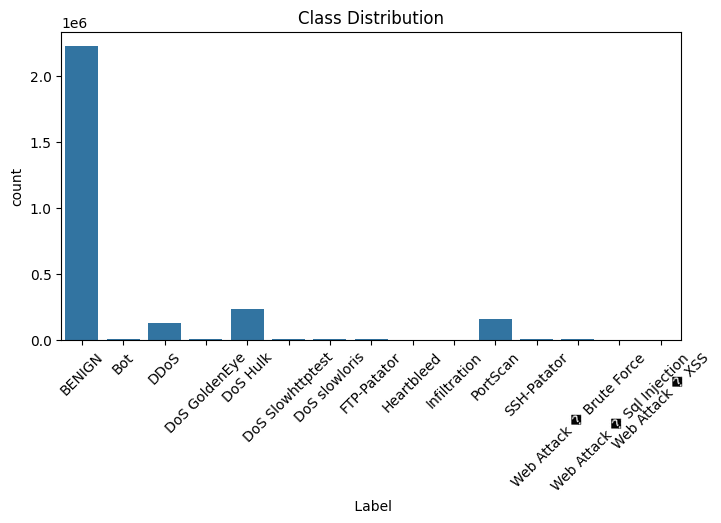

In [ ]:
target_col = ' Label'
plt.figure(figsize=(8, 4))
sns.countplot(x=df[target_col])
plt.title("Class Distribution")
class_names = le.inverse_transform(sorted(df[target_col].unique()))
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.show()

Begnign is the most frequent class. Frequent attacks are DDoS, DoS Hulk and PortScan.

### Visualize feature distributions

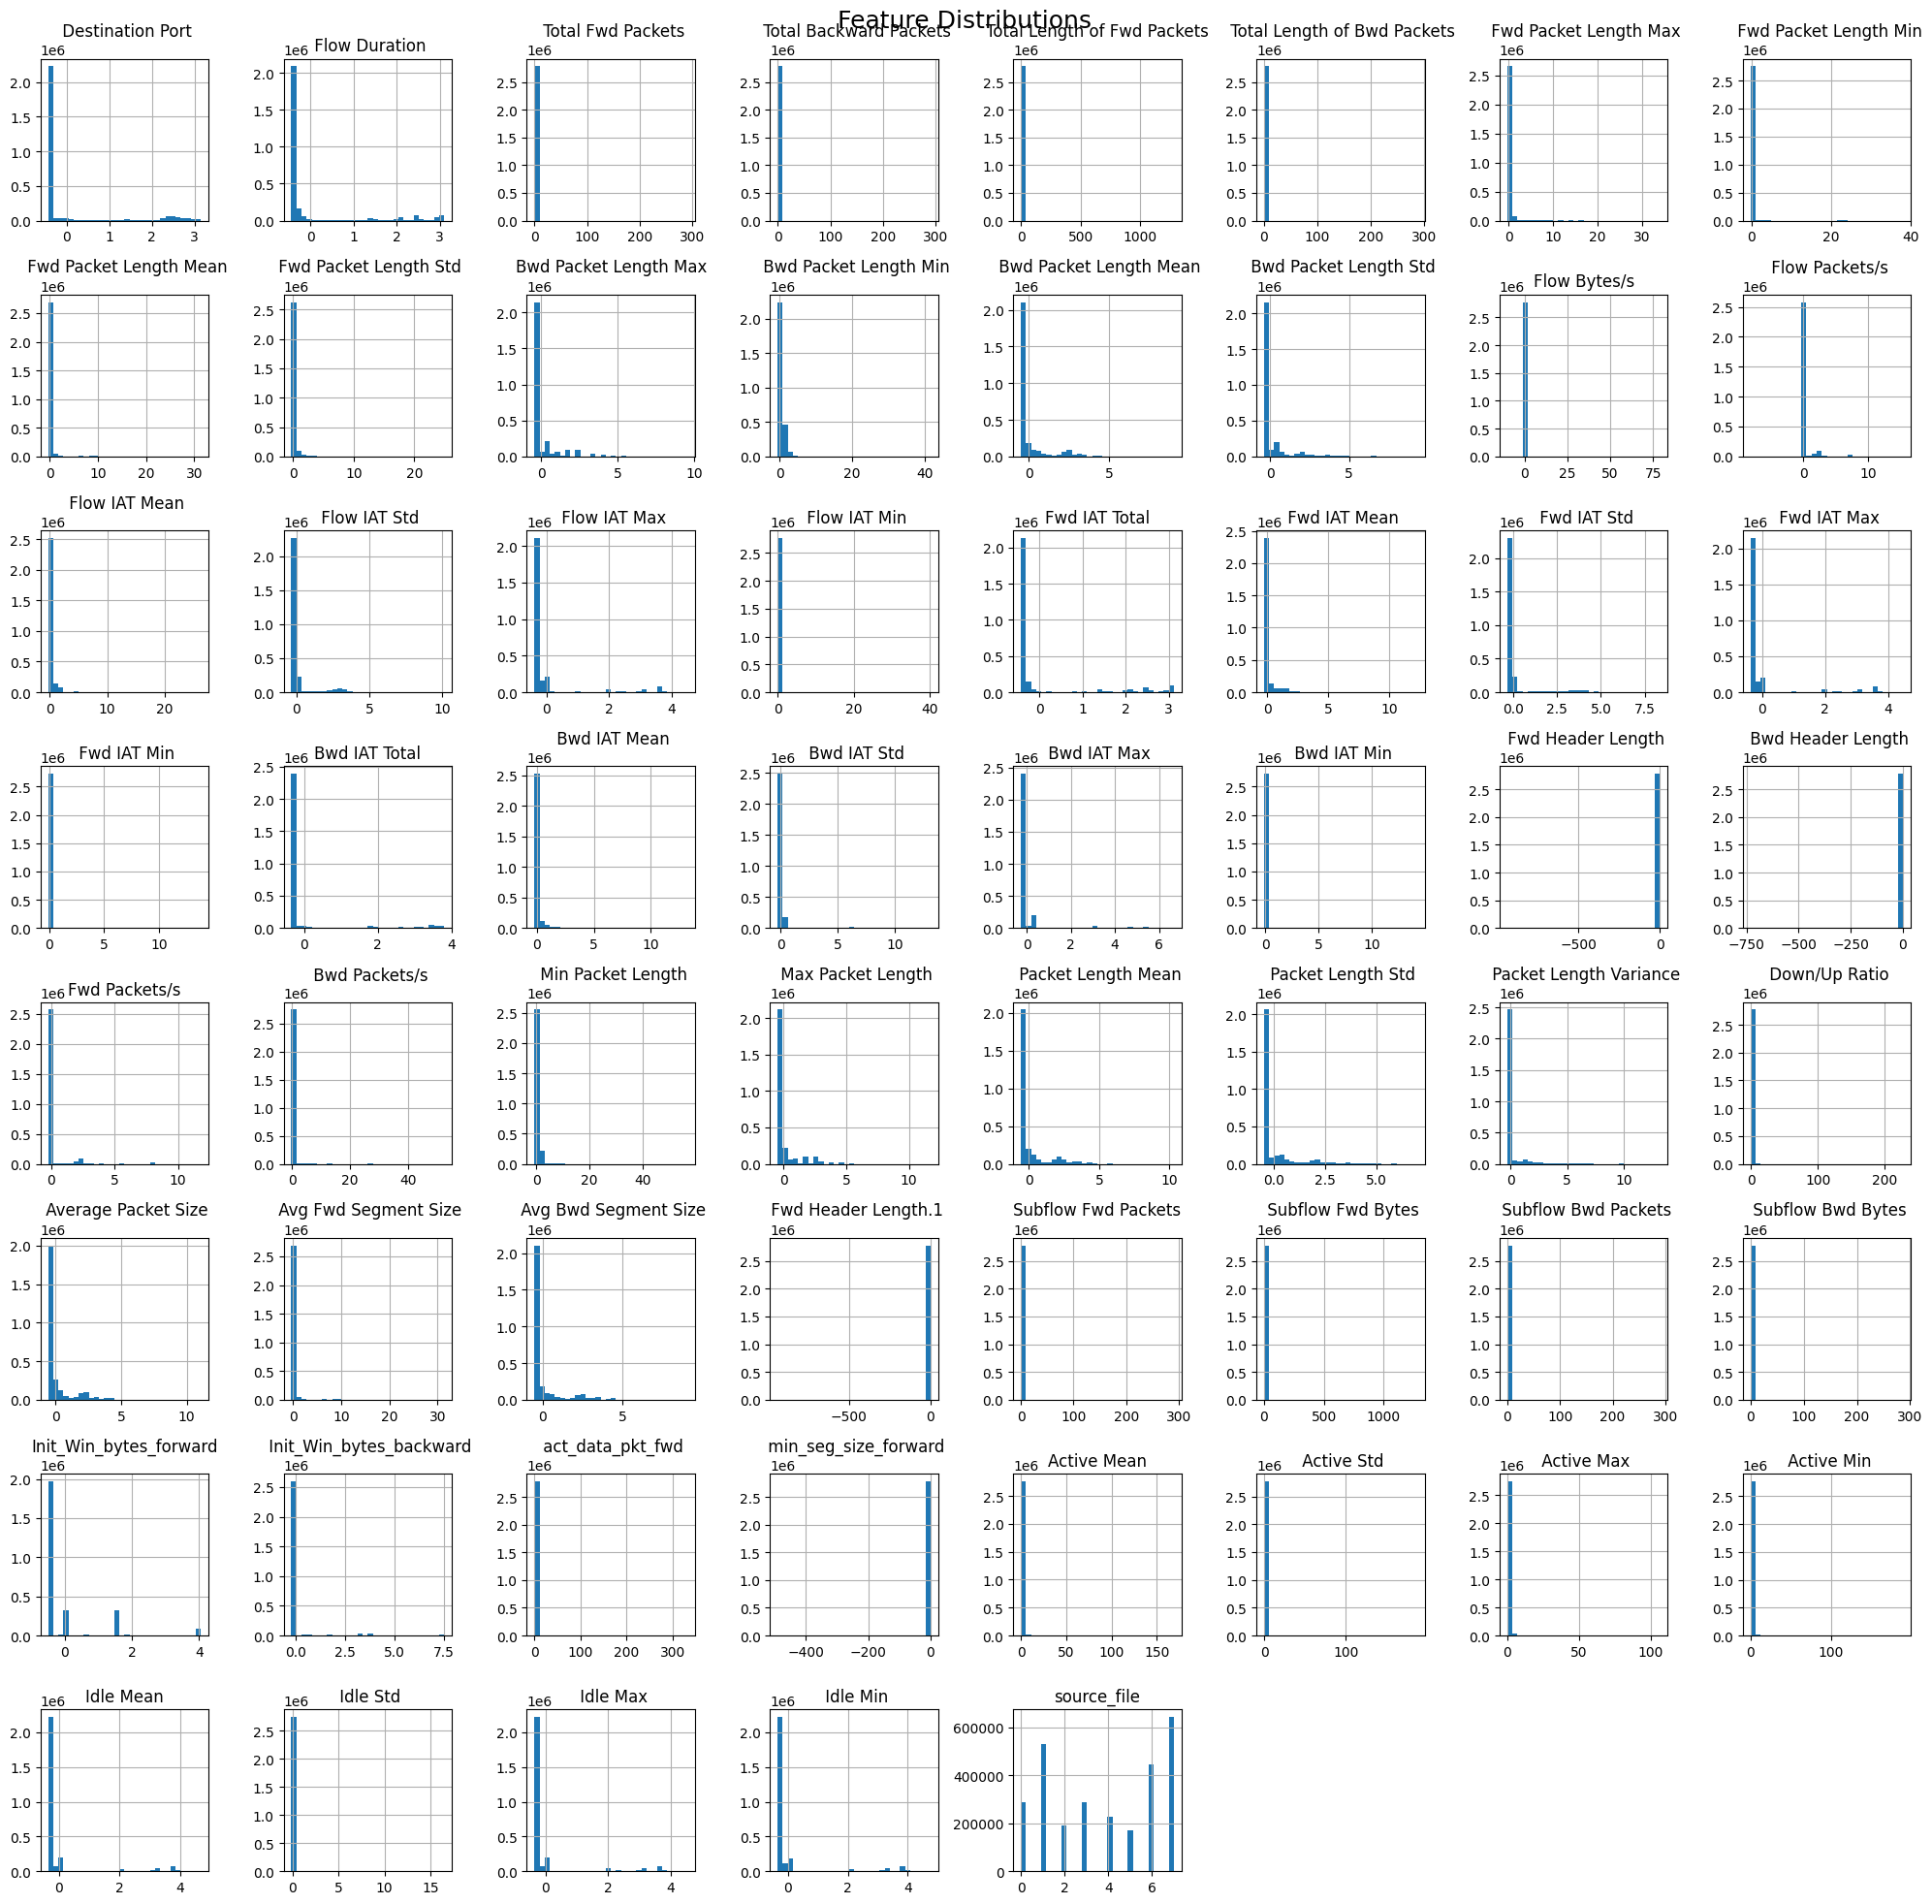

In [ ]:
df[numeric_cols].hist(bins=30, figsize=(20, 20))
plt.suptitle("Feature Distributions", fontsize=18)
plt.tight_layout()
plt.show()

La tu peux aller plus loin en regardant features par features, mais c'est deja pas mal.

### Correlation analysis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2780743 entries, 0 to 2780742
Data columns (total 54 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0    Destination Port            float64
 1    Flow Duration               float64
 2   Total Length of Fwd Packets  float64
 3    Fwd Packet Length Max       float64
 4    Fwd Packet Length Min       float64
 5    Fwd Packet Length Mean      float64
 6    Fwd Packet Length Std       float64
 7   Bwd Packet Length Max        float64
 8    Bwd Packet Length Min       float64
 9    Bwd Packet Length Mean      float64
 10   Bwd Packet Length Std       float64
 11  Flow Bytes/s                 float64
 12   Flow Packets/s              float64
 13   Flow IAT Mean               float64
 14   Flow IAT Std                float64
 15   Flow IAT Max                float64
 16  Fwd IAT Total                float64
 17   Fwd IAT Mean                float64
 18   Fwd IAT Std                 float64
 19  

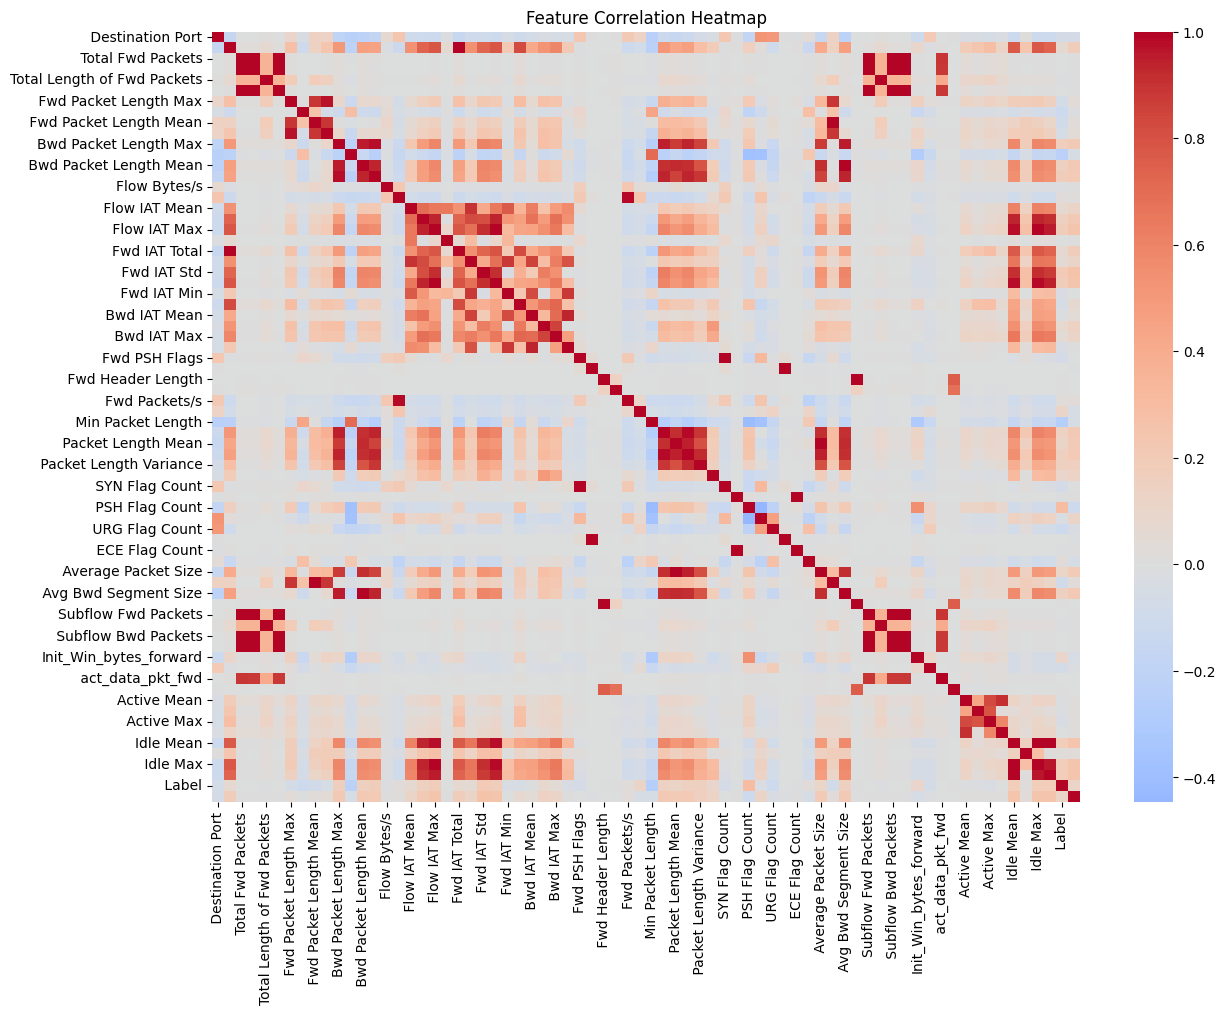

In [ ]:
corr = df.corr()
df = df.drop(corr[" Label"][abs(corr[" Label"])<0.01].index, axis=1)
print(df.head(), df.info())
plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


Les lignes et colonnes manquantes (toutes blanches) sont celles contenant toute la même valeur.

On voit que certaines features sont fortement corrélées entre elles (ex: "Total Fwd Packets" et "Total Backward Packets"), ce qui peut indiquer une redondance d'information, qui serait évitable avec une PCA par exemple.
Certaines features semblent aussi corrélées avec la target (avant dernière ligne et colonne) (ex: "PSH Flag Count" positivement et "Min Packet Length" négativement), ce qui peut indiquer qu'elles sont informatives pour la classification.

### Create train and test datasets, and balance the dataset with SMOTE

In [ ]:
X = df.drop(columns=[target_col])
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


print("Class répartition before SMOTE :")
print(y_train.value_counts())

# Appliquer SMOTE pour équilibrer les classes sur les données d'entraînement
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nClass répartition after SMOTE :")
print(pd.Series(y_train_smote).value_counts())
print(X_train.info(), df.info())

Training set size: (2224594, 53)
Test set size: (556149, 53)
Class répartition before SMOTE :
 Label
0     1780797
4      184479
10     127204
2      102390
7        6356
3        6203
11       4747
6        4615
5        4432
1        1593
12       1195
14        523
9          34
13         19
8           7
Name: count, dtype: int64


KeyboardInterrupt: 

### Pairwise feature relationships

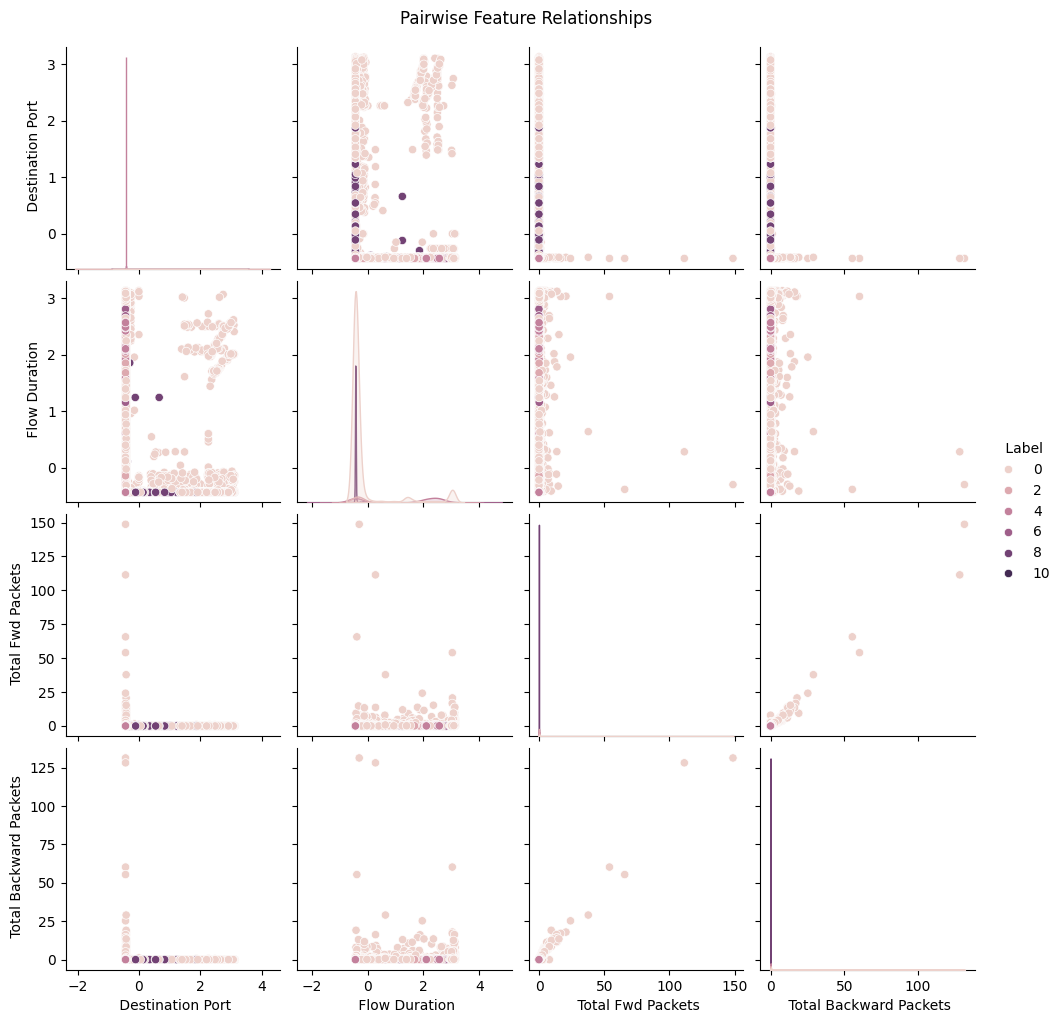

In [ ]:
sample_features = list(numeric_cols[:4])  # visualize only a few to keep plots readable and time reasonable
plot_features = sample_features + [target_col]
sns.pairplot(df[plot_features], hue=target_col, diag_kind="kde")
plt.suptitle("Pairwise Feature Relationships", y=1.02)
plt.show()

# 2. Model Training, Comparison, and Ensemble 

### 2.1 Logistic regression

On the original train set, before SMOTE:

c:\Users\arthu\OneDrive\Efrei\I1\S5\MachineLearning\machineLearningCybersecurity\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\arthu\OneDrive\Efrei\I1\S5\MachineLearning\machineLearningCybersecurity\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

Confusion matrix:  [[8014    0    7    0   20    2    2    6   14    3    0    0]
 [   7    0    0    0    0    0    0    0    2    0    0    0]
 [  20    0  422    0    0    0    0    0    0    0    0    0]
 [   2    0    0   22    0    0    0    0    0    0    0    0]
 [   5    0    3    1  804    0    0    0    0    0    0    0]
 [   4    0    0    0    0   14    1    0    0    0    0    0]
 [   1    0    0    0    0    0   10    1    7    0    0    0]
 [  21    0    0    0    0    0    0   16    0    0    0    0]
 [   2    0    0    0    0    0    0    0  541    0    0    0]
 [  17    0    0    0    0    0    0    0    0    0    0    0]
 [   5    0    0    0    0    0    0    0    0    0    0    0]
 [   4    0    0    0    0    0    0    0    0    0    0    0]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8068
           1       0.00      0.00      0.00         9
           2       0.98      0.95      0.97       442
       

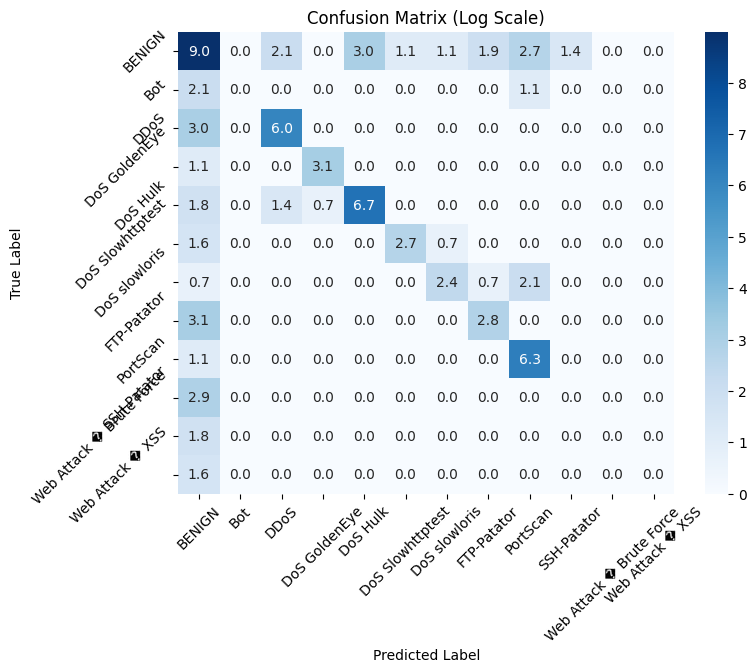

In [ ]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)
models.append({"model" : logistic_regression, "smote": False})

### Evaluate the model
y_pred = logistic_regression.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix: ", conf_matrix)
print(classification_report(y_test, y_pred))

plt.figure(figsize=(8, 6))
# Use log scale for better visualization when one class is very frequent
conf_matrix_log = np.log1p(conf_matrix)  # log(1 + x) to handle zeros
sns.heatmap(conf_matrix_log, annot=True, fmt='.1f', cmap='Blues')
plt.title("Confusion Matrix (Log Scale)")
plt.xlabel("Predicted Label")
plt.xticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, rotation=45)
plt.ylabel("True Label")
plt.yticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, rotation=45)
plt.show()

A lot of attacks are not detected by logistic regression, especially minority classes. The model tends to predict the majority class "Benign" too often. Still, we get decent f1-scores for some classes like DDoS and DoS Hulk.

On the SMOTE balanced train set:

c:\Users\arthu\OneDrive\Efrei\I1\S5\MachineLearning\machineLearningCybersecurity\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion matrix:  [[7158  599   86   11   29   11   29   24   14   45   12   50]
 [   2    7    0    0    0    0    0    0    0    0    0    0]
 [   1    0  441    0    0    0    0    0    0    0    0    0]
 [   0    0    0   24    0    0    0    0    0    0    0    0]
 [   0    0    3    1  809    0    0    0    0    0    0    0]
 [   1    0    0    0    0   18    0    0    0    0    0    0]
 [   0    0    0    0    0    1   18    0    0    0    0    0]
 [   0    0    0    0    0    0    0   37    0    0    0    0]
 [   0    0    0    0    0    0    0    1  541    0    0    1]
 [   0    0    0    0    0    0    0    0    0   16    0    1]
 [   0    0    0    0    0    0    0    0    0    2    3    0]
 [   0    0    0    0    0    0    0    0    0    0    3    1]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      8068
           1       0.01      0.78      0.02         9
           2       0.83      1.00      0.91       442
       

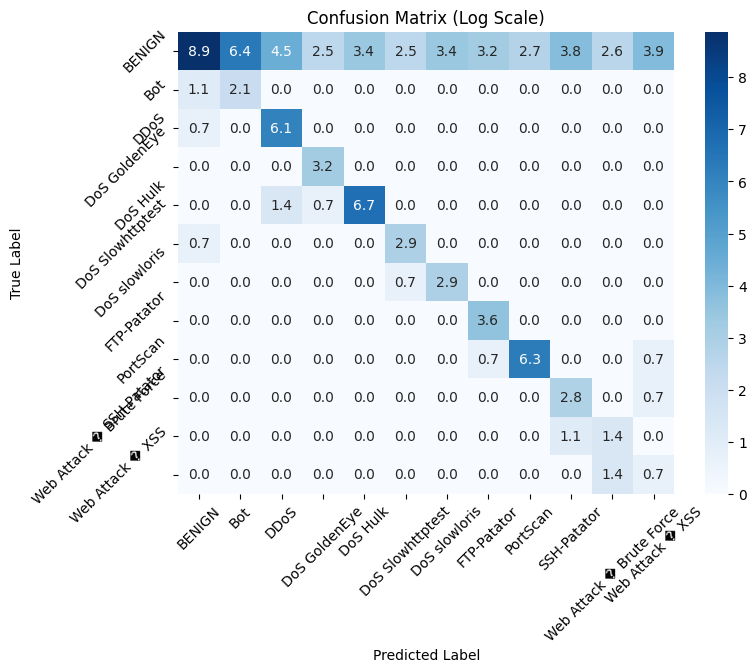

In [ ]:
logistic_regression_smote = LogisticRegression(max_iter=1000)
logistic_regression_smote.fit(X_train_smote, y_train_smote)
models.append({"model" : logistic_regression_smote, "smote": True})

### Evaluate the model
y_pred = logistic_regression_smote.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix: ", conf_matrix)
print(classification_report(y_test, y_pred))

plt.figure(figsize=(8, 6))
# Use log scale for better visualization when one class is very frequent
conf_matrix_log = np.log1p(conf_matrix)  # log(1 + x) to handle zeros
sns.heatmap(conf_matrix_log, annot=True, fmt='.1f', cmap='Blues')
plt.title("Confusion Matrix (Log Scale)")
plt.xlabel("Predicted Label")
plt.xticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, rotation=45)
plt.ylabel("True Label")
plt.yticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, rotation=45)
plt.show()

The Logistic regression model does not converge when trained on SMOTE balanced data, even with increased max_iter. The performance is worse than on the original data, with lower f1-scores for most classes. This may be due to overfitting on synthetic samples generated by SMOTE.

## 2.2 KNN implementation :

On the original train set, before SMOTE:

Confusion matrix:  [[8042    2    1    3   12    0    1    2    2    0    1    2]
 [   4    5    0    0    0    0    0    0    0    0    0    0]
 [   0    0  442    0    0    0    0    0    0    0    0    0]
 [   0    0    0   24    0    0    0    0    0    0    0    0]
 [   3    0    1    0  809    0    0    0    0    0    0    0]
 [   1    0    0    0    0   18    0    0    0    0    0    0]
 [   0    0    0    0    0    0   19    0    0    0    0    0]
 [   1    0    0    0    0    0    0   36    0    0    0    0]
 [   1    0    0    0    0    0    0    0  542    0    0    0]
 [   1    0    0    0    0    0    0    0    0   16    0    0]
 [   2    0    0    0    0    0    0    0    0    0    3    0]
 [   0    0    0    0    0    0    0    0    0    0    4    0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8068
           1       0.71      0.56      0.62         9
           2       1.00      1.00      1.00       442
       

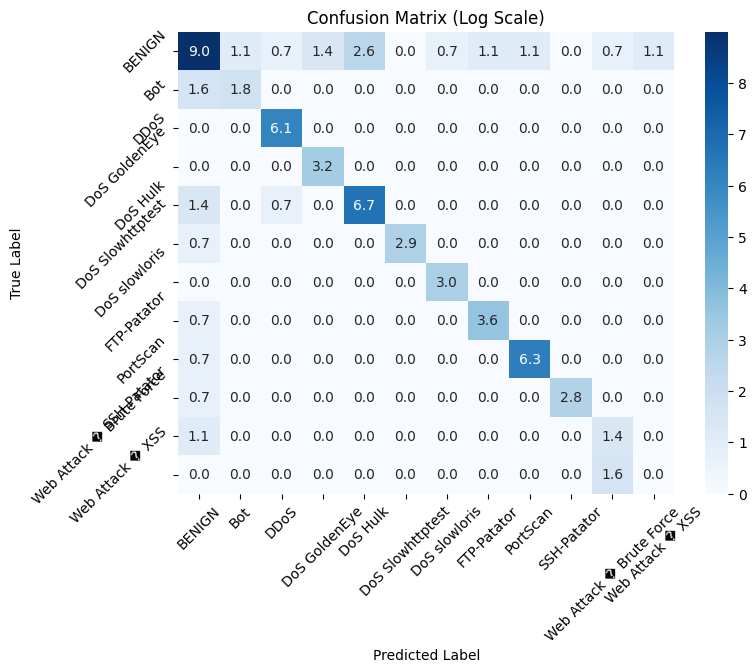

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train, y_train)
models.append({"model" : knn, "smote": False})

y_pred = knn.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix: ", conf_matrix)
print(classification_report(y_test, y_pred))


plt.figure(figsize=(8, 6))
# Use log scale for better visualization when one class is very frequent
conf_matrix_log = np.log1p(conf_matrix)  # log(1 + x) to handle zeros
sns.heatmap(conf_matrix_log, annot=True, fmt='.1f', cmap='Blues')
plt.title("Confusion Matrix (Log Scale)")
plt.xlabel("Predicted Label")
plt.xticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, rotation=45)
plt.ylabel("True Label")
plt.yticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, rotation=45)
plt.show()

On the SMOTE balanced train set:

Confusion matrix:  [[8016   12    1    4   14    1    6    3    4    4    3    0]
 [   2    7    0    0    0    0    0    0    0    0    0    0]
 [   0    0  442    0    0    0    0    0    0    0    0    0]
 [   0    0    0   24    0    0    0    0    0    0    0    0]
 [   0    0    0    1  812    0    0    0    0    0    0    0]
 [   0    0    0    0    0   19    0    0    0    0    0    0]
 [   0    0    0    0    0    0   19    0    0    0    0    0]
 [   0    0    0    0    0    0    0   37    0    0    0    0]
 [   0    0    0    0    0    0    0    0  543    0    0    0]
 [   1    0    0    0    0    0    0    0    0   16    0    0]
 [   2    0    0    0    0    0    0    0    0    0    3    0]
 [   0    0    0    0    0    0    0    0    0    0    3    1]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      8068
           1       0.37      0.78      0.50         9
           2       1.00      1.00      1.00       442
       

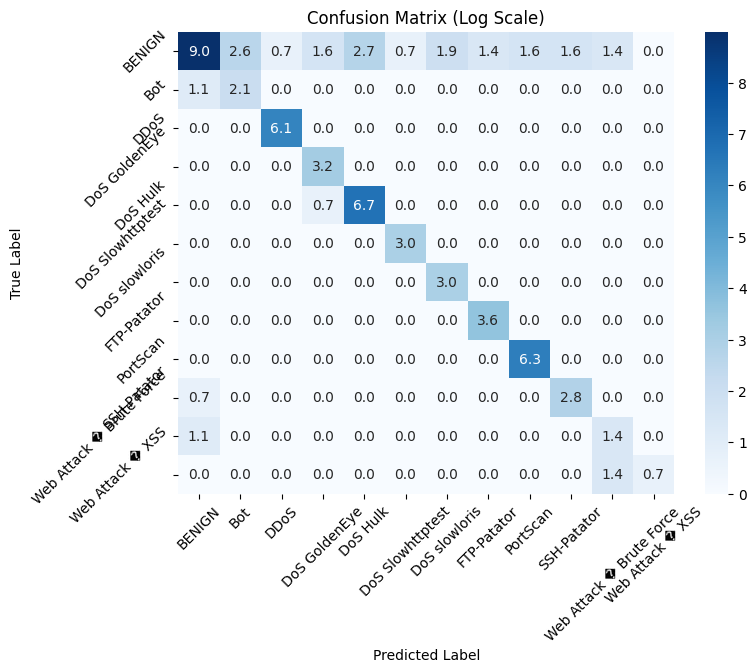

In [ ]:
knn_smote = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_smote.fit(X_train_smote, y_train_smote)
models.append({"model" : knn_smote, "smote": True})
y_pred = knn_smote.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix: ", conf_matrix)
print(classification_report(y_test, y_pred))


plt.figure(figsize=(8, 6))
# Use log scale for better visualization when one class is very frequent
conf_matrix_log = np.log1p(conf_matrix)  # log(1 + x) to handle zeros
sns.heatmap(conf_matrix_log, annot=True, fmt='.1f', cmap='Blues')
plt.title("Confusion Matrix (Log Scale)")
plt.xlabel("Predicted Label")
plt.xticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, rotation=45)
plt.ylabel("True Label")
plt.yticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, rotation=45)
plt.show()

Same as logistic regression, the performance is worse when trained on SMOTE data.

## 2.4 Random Forest Classification

On the original train set, before SMOTE:

Random Forest Results:
Confusion matrix:  [[8065    0    0    1    2    0    0    0    0    0    0    0]
 [   4    5    0    0    0    0    0    0    0    0    0    0]
 [   0    0  442    0    0    0    0    0    0    0    0    0]
 [   0    0    0   24    0    0    0    0    0    0    0    0]
 [   2    0    0    0  811    0    0    0    0    0    0    0]
 [   1    0    0    0    0   17    1    0    0    0    0    0]
 [   0    0    0    0    0    0   19    0    0    0    0    0]
 [   0    0    0    0    0    0    0   37    0    0    0    0]
 [   1    0    0    0    0    0    0    0  542    0    0    0]
 [   1    0    0    0    0    0    0    0    0   16    0    0]
 [   3    0    0    0    0    0    0    0    0    0    2    0]
 [   0    0    0    0    0    0    0    0    0    0    4    0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8068
           1       1.00      0.56      0.71         9
           2       1.00      1.00     

c:\Users\arthu\OneDrive\Efrei\I1\S5\MachineLearning\machineLearningCybersecurity\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\arthu\OneDrive\Efrei\I1\S5\MachineLearning\machineLearningCybersecurity\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\arthu\OneDrive\Efrei\I1\S5\MachineLearning\machineLearningCybersecurity\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sa

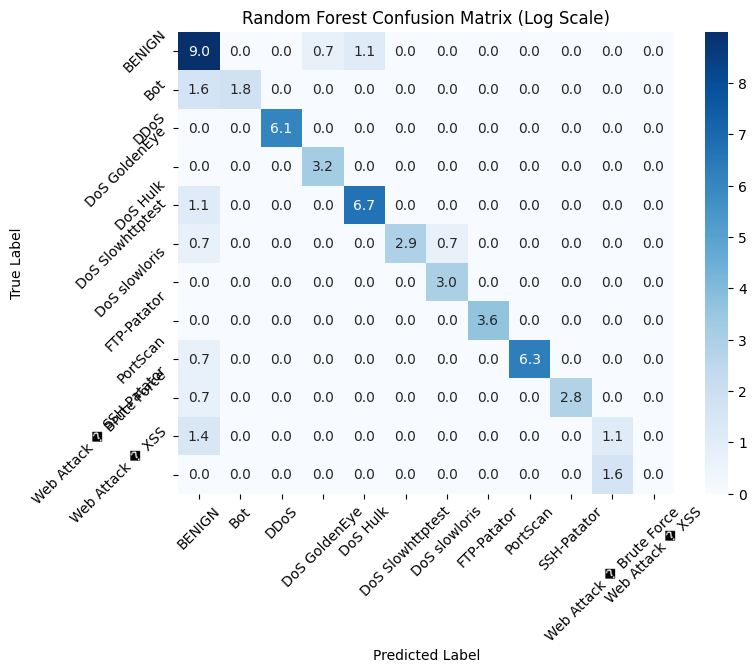

In [ ]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
random_forest.fit(X_train, y_train)
models.append({"model" : random_forest, "smote": False})
y_pred_rf = random_forest.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred_rf)
print("Random Forest Results:")
print("Confusion matrix: ", conf_matrix)
print(classification_report(y_test, y_pred_rf))

plt.figure(figsize=(8, 6))
conf_matrix_log = np.log1p(conf_matrix)
sns.heatmap(conf_matrix_log, annot=True, fmt='.1f', cmap='Blues')
plt.title("Random Forest Confusion Matrix (Log Scale)")
plt.xlabel("Predicted Label")
plt.xticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, rotation=45)
plt.ylabel("True Label")
plt.yticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, rotation=45)
plt.show()

On the SMOTE balanced train set:

Random Forest Results:
Confusion matrix:  [[8062    1    0    1    2    1    0    0    0    0    1    0]
 [   3    6    0    0    0    0    0    0    0    0    0    0]
 [   0    0  442    0    0    0    0    0    0    0    0    0]
 [   0    0    0   24    0    0    0    0    0    0    0    0]
 [   2    0    0    0  811    0    0    0    0    0    0    0]
 [   0    0    0    0    0   18    1    0    0    0    0    0]
 [   0    0    0    0    0    0   19    0    0    0    0    0]
 [   0    0    0    0    0    0    0   37    0    0    0    0]
 [   0    0    0    0    0    0    0    0  543    0    0    0]
 [   1    0    0    0    0    0    0    0    0   16    0    0]
 [   2    0    0    0    0    0    0    0    0    0    3    0]
 [   0    0    0    0    0    0    0    0    0    0    2    2]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8068
           1       0.86      0.67      0.75         9
           2       1.00      1.00     

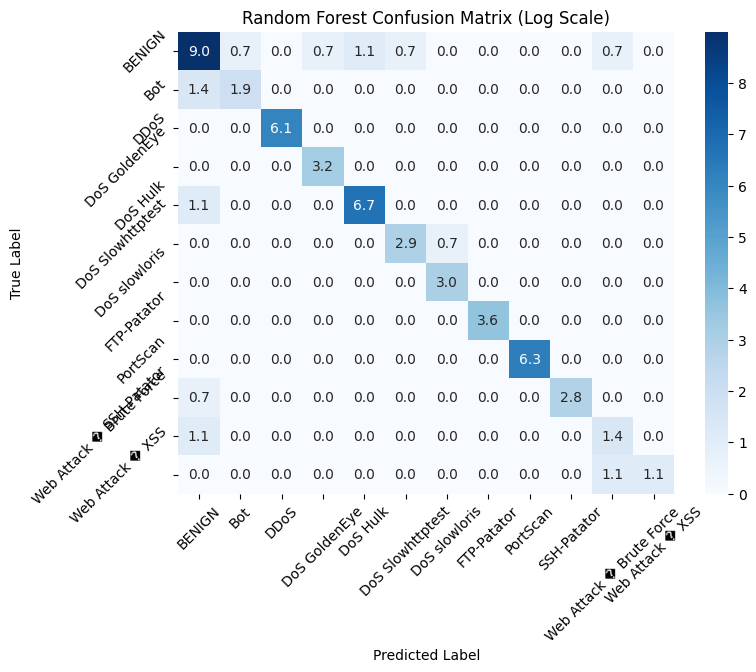

In [ ]:
random_forest_smote = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
random_forest_smote.fit(X_train_smote, y_train_smote)
models.append({"model" : random_forest_smote, "smote": True})
y_pred_rf = random_forest_smote.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred_rf)
print("Random Forest Results:")
print("Confusion matrix: ", conf_matrix)
print(classification_report(y_test, y_pred_rf))

plt.figure(figsize=(8, 6))
conf_matrix_log = np.log1p(conf_matrix)
sns.heatmap(conf_matrix_log, annot=True, fmt='.1f', cmap='Blues')
plt.title("Random Forest Confusion Matrix (Log Scale)")
plt.xlabel("Predicted Label")
plt.xticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, rotation=45)
plt.ylabel("True Label")
plt.yticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, rotation=45)
plt.show()

## 2.5 Gradient Boosting Classification

On the original train set, before SMOTE:

[0]	validation_0-mlogloss:1.00574
[1]	validation_0-mlogloss:0.69199
[2]	validation_0-mlogloss:0.49702
[3]	validation_0-mlogloss:0.36451
[4]	validation_0-mlogloss:0.27057
[5]	validation_0-mlogloss:0.20249
[6]	validation_0-mlogloss:0.15279
[7]	validation_0-mlogloss:0.11627
[8]	validation_0-mlogloss:0.08944
[9]	validation_0-mlogloss:0.06951
[10]	validation_0-mlogloss:0.05452
[11]	validation_0-mlogloss:0.04334
[12]	validation_0-mlogloss:0.03460
[13]	validation_0-mlogloss:0.02785
[14]	validation_0-mlogloss:0.02265
[15]	validation_0-mlogloss:0.01871
[16]	validation_0-mlogloss:0.01561
[17]	validation_0-mlogloss:0.01334
[18]	validation_0-mlogloss:0.01158
[19]	validation_0-mlogloss:0.01026
[20]	validation_0-mlogloss:0.00927
[21]	validation_0-mlogloss:0.00844
[22]	validation_0-mlogloss:0.00773
[23]	validation_0-mlogloss:0.00720
[24]	validation_0-mlogloss:0.00680
[25]	validation_0-mlogloss:0.00631
[26]	validation_0-mlogloss:0.00606
[27]	validation_0-mlogloss:0.00588
[28]	validation_0-mlogloss:0.0

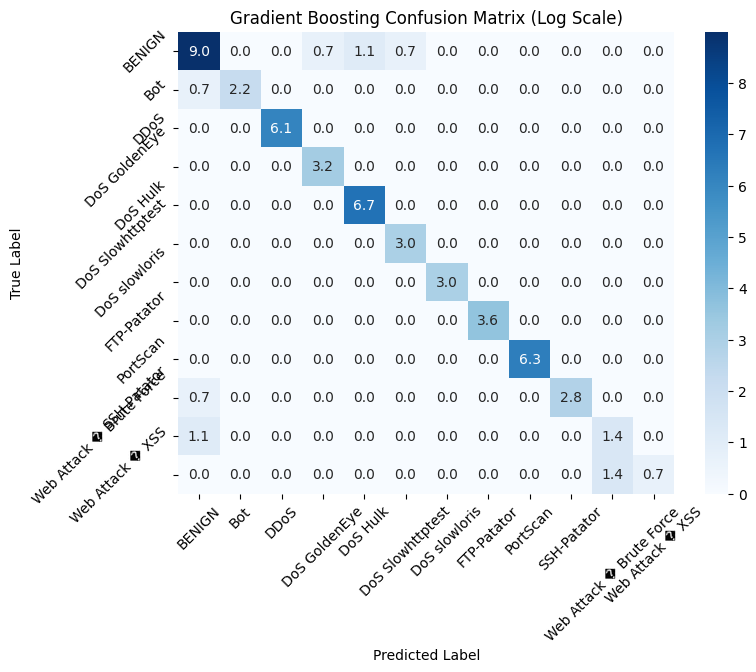

In [ ]:
gradient_boosting = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2)
gradient_boosting.fit(X_train, y_train, eval_set=[(X_test, y_test)])
models.append({"model" : gradient_boosting, "smote": False})
y_pred_gb = gradient_boosting.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_gb)
print("Gradient Boosting Results:")
print("Confusion matrix: ", conf_matrix)
print(classification_report(y_test, y_pred_gb))

plt.figure(figsize=(8, 6))
conf_matrix_log = np.log1p(conf_matrix)
sns.heatmap(conf_matrix_log, annot=True, fmt='.1f', cmap='Blues')
plt.title("Gradient Boosting Confusion Matrix (Log Scale)")
plt.xlabel("Predicted Label")
plt.xticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, rotation=45)
plt.ylabel("True Label")
plt.yticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, rotation=45)
plt.show()

On the SMOTE balanced train set:

[0]	validation_0-mlogloss:1.24058
[1]	validation_0-mlogloss:0.82534
[2]	validation_0-mlogloss:0.60220
[3]	validation_0-mlogloss:0.44161
[4]	validation_0-mlogloss:0.33313
[5]	validation_0-mlogloss:0.25540
[6]	validation_0-mlogloss:0.19896
[7]	validation_0-mlogloss:0.15780
[8]	validation_0-mlogloss:0.12754
[9]	validation_0-mlogloss:0.10024
[10]	validation_0-mlogloss:0.07889
[11]	validation_0-mlogloss:0.06269
[12]	validation_0-mlogloss:0.05028
[13]	validation_0-mlogloss:0.04115
[14]	validation_0-mlogloss:0.03384
[15]	validation_0-mlogloss:0.02826
[16]	validation_0-mlogloss:0.02386
[17]	validation_0-mlogloss:0.02000
[18]	validation_0-mlogloss:0.01730
[19]	validation_0-mlogloss:0.01515
[20]	validation_0-mlogloss:0.01375
[21]	validation_0-mlogloss:0.01225
[22]	validation_0-mlogloss:0.01113
[23]	validation_0-mlogloss:0.01016
[24]	validation_0-mlogloss:0.00934
[25]	validation_0-mlogloss:0.00888
[26]	validation_0-mlogloss:0.00845
[27]	validation_0-mlogloss:0.00817
[28]	validation_0-mlogloss:0.0

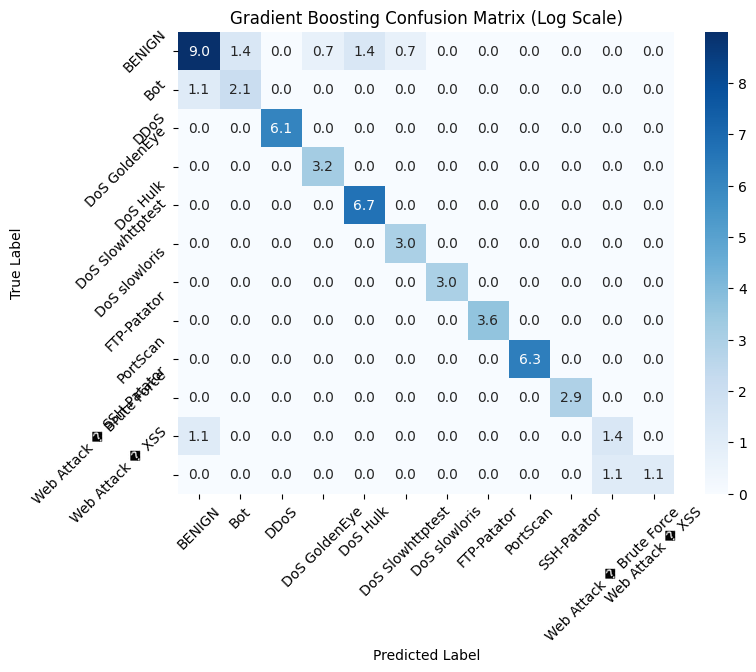

In [ ]:
gradient_boosting_smote = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2)
gradient_boosting_smote.fit(X_train_smote, y_train_smote, eval_set=[(X_test, y_test)])
models.append({"model" : gradient_boosting_smote, "smote": True})
y_pred_gb = gradient_boosting_smote.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred_gb)
print("Gradient Boosting Results:")
print("Confusion matrix: ", conf_matrix)
print(classification_report(y_test, y_pred_gb))

plt.figure(figsize=(8, 6))
conf_matrix_log = np.log1p(conf_matrix)
sns.heatmap(conf_matrix_log, annot=True, fmt='.1f', cmap='Blues')
plt.title("Gradient Boosting Confusion Matrix (Log Scale)")
plt.xlabel("Predicted Label")
plt.xticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, rotation=45)
plt.ylabel("True Label")
plt.yticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, rotation=45)
plt.show()

# 2.6 Ensemble Methods

## 2.6.1 Voting Classifier

In [ ]:
# Create base models for voting ensemble
lr_voting = LogisticRegression(max_iter=1000)
knn_voting = KNeighborsClassifier(n_neighbors=5, weights='distance')
rf_voting = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')



# Hard Voting Classifier
hard_voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr_voting),
        ('knn', knn_voting), 
        ('rf', rf_voting),
    ],
    voting='hard'
)

print("Training Hard Voting Classifier...")
hard_voting_clf.fit(X_train_smote, y_train_smote)
models.append({"model" : hard_voting_clf, "smote" : True})
y_pred_hard = hard_voting_clf.predict(X_test)

print("Hard Voting Results:")
print(classification_report(y_test, y_pred_hard))

# Soft Voting Classifier  
soft_voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr_voting),
        ('knn', knn_voting),
        ('rf', rf_voting),
    ],
    voting='soft'
)

print("\nTraining Soft Voting Classifier...")
soft_voting_clf.fit(X_train_smote, y_train_smote)
models.append({"model" : soft_voting_clf, "smote" : True})

y_pred_soft = soft_voting_clf.predict(X_test)

print("Soft Voting Results:")
print(classification_report(y_test, y_pred_soft))

Training Hard Voting Classifier...


KeyboardInterrupt: 

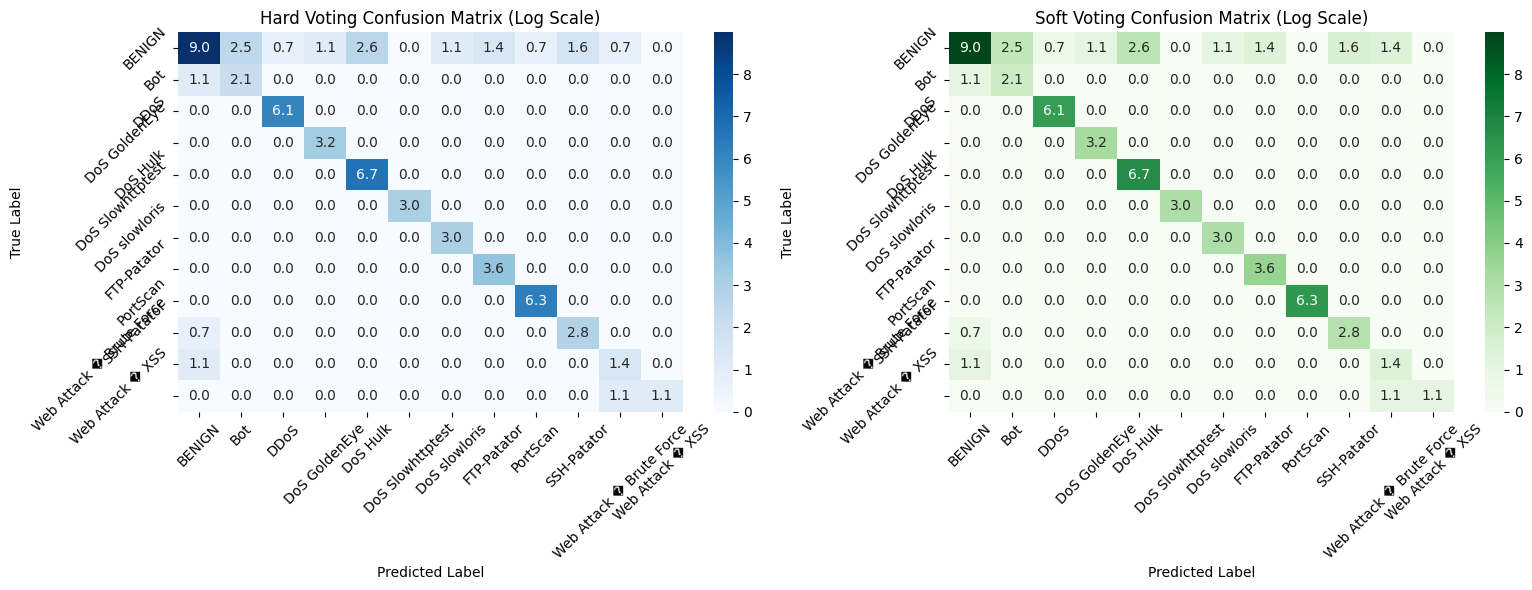

In [ ]:
# Visualize voting results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Hard voting confusion matrix
conf_matrix_hard = confusion_matrix(y_test, y_pred_hard)
conf_matrix_hard_log = np.log1p(conf_matrix_hard)
sns.heatmap(conf_matrix_hard_log, annot=True, fmt='.1f', cmap='Blues', ax=axes[0])
axes[0].set_title("Hard Voting Confusion Matrix (Log Scale)")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")
axes[0].set_xticks(np.arange(len(class_names))+0.5)
axes[0].set_xticklabels(class_names, rotation=45)
axes[0].set_yticks(np.arange(len(class_names))+0.5)
axes[0].set_yticklabels(class_names, rotation=45)

# Soft voting confusion matrix
conf_matrix_soft = confusion_matrix(y_test, y_pred_soft)
conf_matrix_soft_log = np.log1p(conf_matrix_soft)
sns.heatmap(conf_matrix_soft_log, annot=True, fmt='.1f', cmap='Greens', ax=axes[1])
axes[1].set_title("Soft Voting Confusion Matrix (Log Scale)")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")
axes[1].set_xticks(np.arange(len(class_names))+0.5)
axes[1].set_xticklabels(class_names, rotation=45)
axes[1].set_yticks(np.arange(len(class_names))+0.5)
axes[1].set_yticklabels(class_names, rotation=45)

plt.tight_layout()
plt.show()

## 2.6.2 Stacking Classifier

Training Stacking Classifier...


c:\Users\arthu\OneDrive\Efrei\I1\S5\MachineLearning\machineLearningCybersecurity\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\arthu\OneDrive\Efrei\I1\S5\MachineLearning\machineLearningCybersecurity\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also w

Stacking Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8068
           1       0.83      0.56      0.67         9
           2       1.00      1.00      1.00       442
           3       0.96      1.00      0.98        24
           4       1.00      1.00      1.00       813
           5       1.00      0.89      0.94        19
           6       0.95      1.00      0.97        19
           7       1.00      1.00      1.00        37
           8       1.00      1.00      1.00       543
           9       1.00      0.94      0.97        17
          10       0.60      0.60      0.60         5
          11       1.00      0.50      0.67         4

    accuracy                           1.00     10000
   macro avg       0.94      0.87      0.90     10000
weighted avg       1.00      1.00      1.00     10000



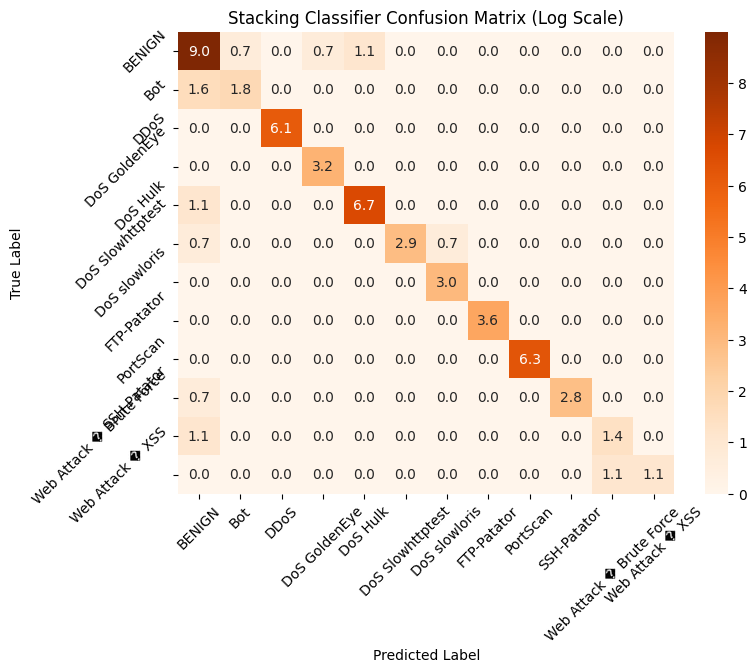

In [ ]:
# Create base models for stacking
base_models = [
    ('lr', LogisticRegression()),
    ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance')),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')),
]

# Use Random Forest as meta-learner
meta_learner = RandomForestClassifier(n_estimators=50, random_state=42)

# Create stacking classifier
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=5  # Use 5-fold cross-validation for generating meta-features
)

print("Training Stacking Classifier...")
stacking_clf.fit(X_train_smote, y_train_smote)
models.append({"model" : stacking_clf, "smote" : True})
y_pred_stack = stacking_clf.predict(X_test)

print("Stacking Results:")
print(classification_report(y_test, y_pred_stack))

# Visualize stacking results
conf_matrix_stack = confusion_matrix(y_test, y_pred_stack)
plt.figure(figsize=(8, 6))
conf_matrix_stack_log = np.log1p(conf_matrix_stack)
sns.heatmap(conf_matrix_stack_log, annot=True, fmt='.1f', cmap='Oranges')
plt.title("Stacking Classifier Confusion Matrix (Log Scale)")
plt.xlabel("Predicted Label")
plt.xticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, rotation=45)
plt.ylabel("True Label")
plt.yticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, rotation=45)
plt.show()

## 2.7 Model Performance Comparison

Model Performance Comparison:
              Model  Accuracy  F1-Score (Macro)  F1-Score (Weighted)
      Random Forest    0.9980            0.8566               0.9978
                KNN    0.9957            0.8240               0.9957
        Soft Voting    0.9957            0.7822               0.9952
        Hard Voting    0.9916            0.6919               0.9903
Logistic Regression    0.9857            0.5960               0.9838
         SVM (Best)    0.9857            0.5236               0.9819
  Gradient Boosting    0.0240            0.1137               0.0307


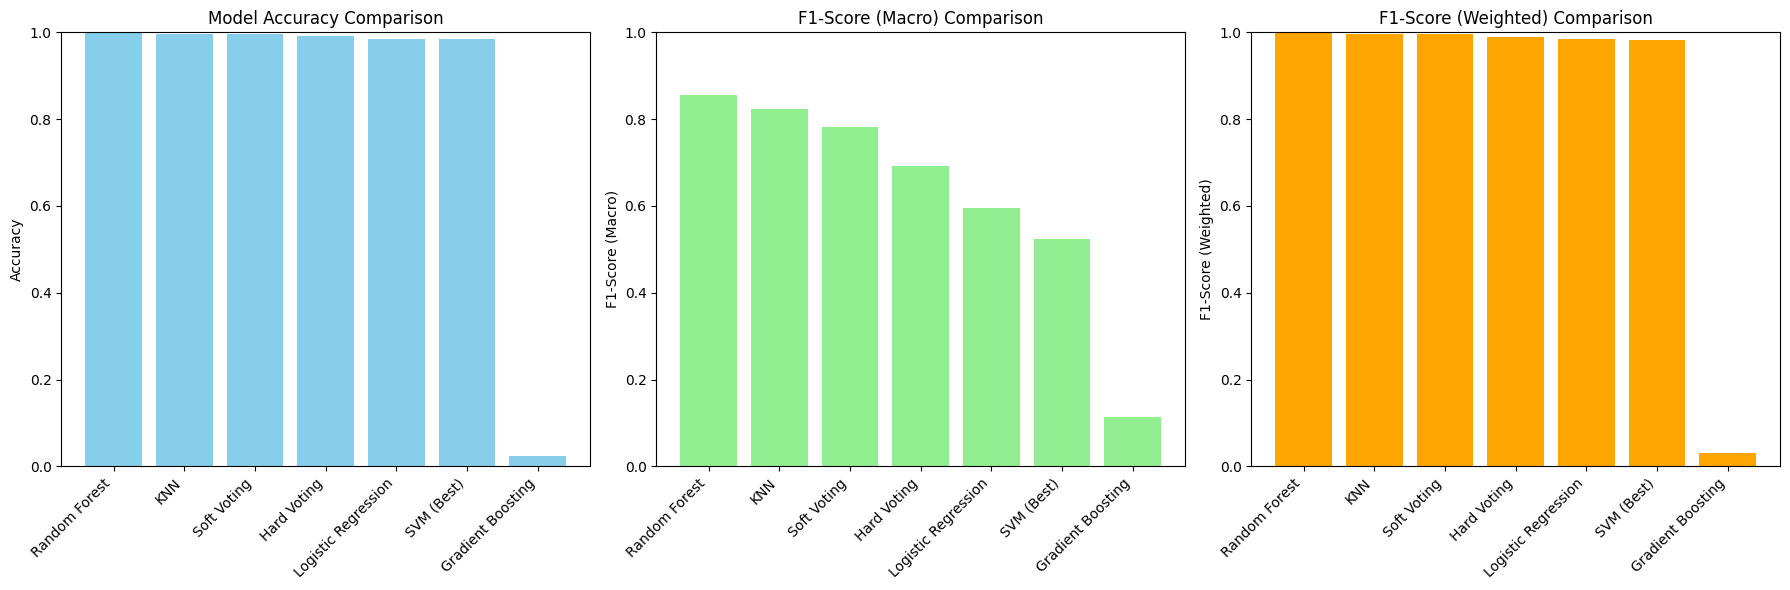

In [ ]:
# Get predictions from all models for comparison
models_to_compare = {
    'Logistic Regression': logistic_regression,
    'KNN': knn,
    'Random Forest': random_forest,
    'Gradient Boosting': gradient_boosting,
    'Hard Voting': hard_voting_clf,
    'Soft Voting': soft_voting_clf,
    'Stacking': stacking_clf
}

# Calculate metrics for each model
results = []
for name, model in models_to_compare.items():
    if name in ['Hard Voting', 'Soft Voting', 'Stacking']:
        # These models are already trained and we have their predictions
        if name == 'Hard Voting':
            y_pred = y_pred_hard
        elif name == 'Soft Voting':
            y_pred = y_pred_soft
        else:  # Stacking
            pass
            y_pred = y_pred_stack
    else:
        y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'F1-Score (Macro)': f1_macro,
        'F1-Score (Weighted)': f1_weighted
    })

# Create comparison DataFrame
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.sort_values('F1-Score (Weighted)', ascending=False)

print("Model Performance Comparison:")
print("=" * 80)
print(comparison_df.to_string(index=False, float_format='%.4f'))

# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Accuracy comparison
axes[0].bar(range(len(comparison_df)), comparison_df['Accuracy'], color='skyblue')
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(range(len(comparison_df)))
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0].set_ylim(0, 1)

# F1-Score (Macro) comparison
axes[1].bar(range(len(comparison_df)), comparison_df['F1-Score (Macro)'], color='lightgreen')
axes[1].set_title('F1-Score (Macro) Comparison')
axes[1].set_ylabel('F1-Score (Macro)')
axes[1].set_xticks(range(len(comparison_df)))
axes[1].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[1].set_ylim(0, 1)

# F1-Score (Weighted) comparison
axes[2].bar(range(len(comparison_df)), comparison_df['F1-Score (Weighted)'], color='orange')
axes[2].set_title('F1-Score (Weighted) Comparison')
axes[2].set_ylabel('F1-Score (Weighted)')
axes[2].set_xticks(range(len(comparison_df)))
axes[2].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()

## 2.8 Feature Importance Analysis

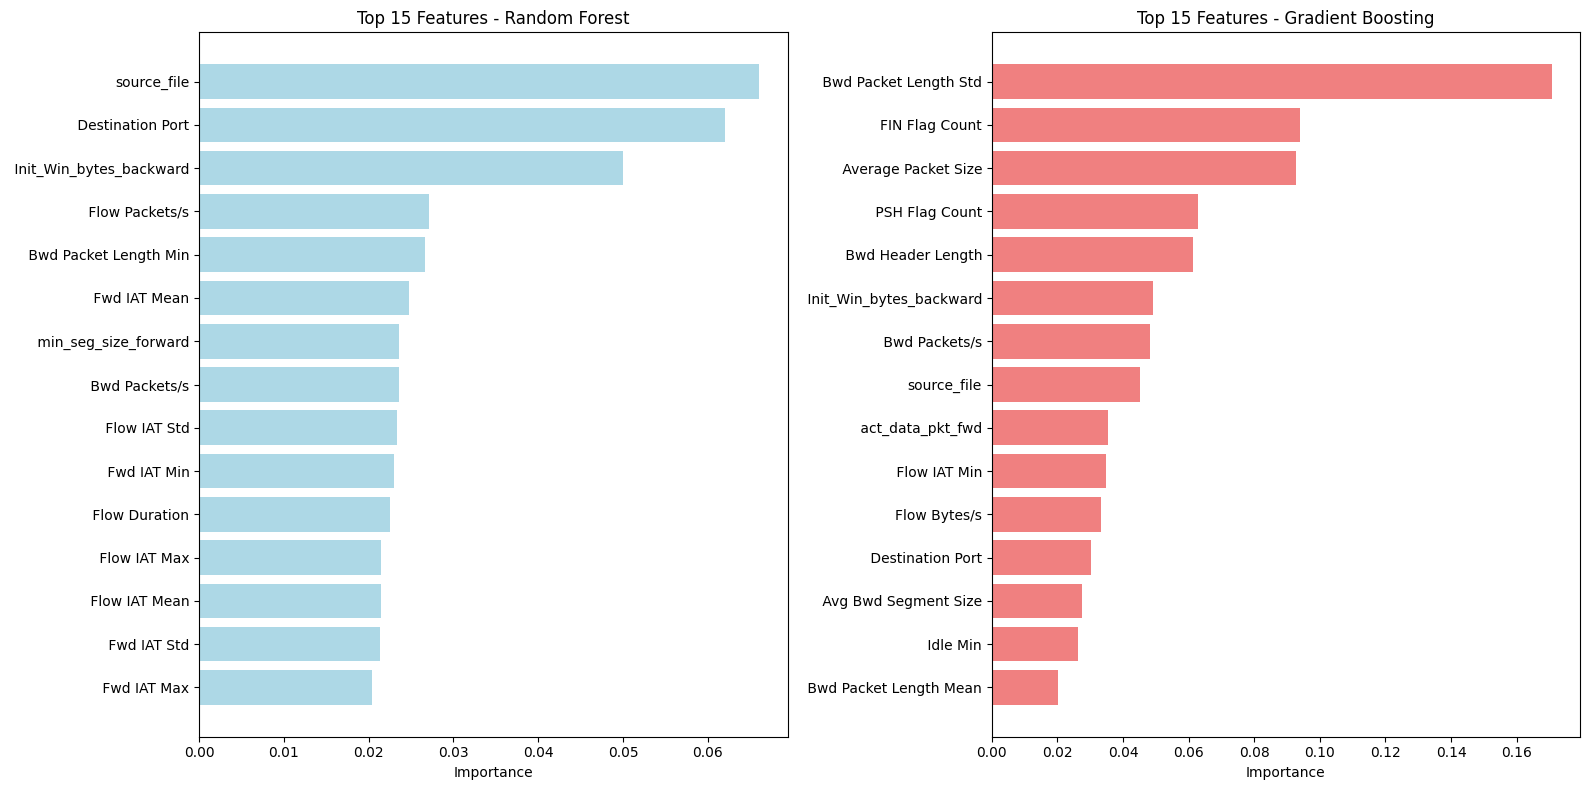

Top 10 Most Important Features (Random Forest):
                 feature  importance
             source_file    0.066104
        Destination Port    0.062076
 Init_Win_bytes_backward    0.049964
          Flow Packets/s    0.027156
   Bwd Packet Length Min    0.026664
            Fwd IAT Mean    0.024738
    min_seg_size_forward    0.023556
           Bwd Packets/s    0.023542
            Flow IAT Std    0.023337
             Fwd IAT Min    0.022962

Top 10 Most Important Features (Gradient Boosting):
                 feature  importance
   Bwd Packet Length Std    0.170775
          FIN Flag Count    0.093926
     Average Packet Size    0.092818
          PSH Flag Count    0.062785
       Bwd Header Length    0.061218
 Init_Win_bytes_backward    0.049214
           Bwd Packets/s    0.048103
             source_file    0.045149
        act_data_pkt_fwd    0.035579
            Flow IAT Min    0.034932


In [ ]:
# Extract feature importance from tree-based models
feature_names = X.columns

# Random Forest feature importance
rf_importance = random_forest.feature_importances_
rf_feature_df = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_importance
}).sort_values('importance', ascending=False)

# Gradient Boosting feature importance
gb_importance = gradient_boosting.feature_importances_
gb_feature_df = pd.DataFrame({
    'feature': feature_names,
    'importance': gb_importance
}).sort_values('importance', ascending=False)

# Plot feature importance comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top 15 features from Random Forest
top_rf_features = rf_feature_df.head(15)
axes[0].barh(range(len(top_rf_features)), top_rf_features['importance'], color='lightblue')
axes[0].set_yticks(range(len(top_rf_features)))
axes[0].set_yticklabels(top_rf_features['feature'])
axes[0].set_xlabel('Importance')
axes[0].set_title('Top 15 Features - Random Forest')
axes[0].invert_yaxis()

# Top 15 features from Gradient Boosting
top_gb_features = gb_feature_df.head(15)
axes[1].barh(range(len(top_gb_features)), top_gb_features['importance'], color='lightcoral')
axes[1].set_yticks(range(len(top_gb_features)))
axes[1].set_yticklabels(top_gb_features['feature'])
axes[1].set_xlabel('Importance')
axes[1].set_title('Top 15 Features - Gradient Boosting')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("Top 10 Most Important Features (Random Forest):")
print(rf_feature_df.head(10).to_string(index=False))

print("\nTop 10 Most Important Features (Gradient Boosting):")
print(gb_feature_df.head(10).to_string(index=False))

# 6. MLflow Tracking 

In [ ]:
"""mlf.set_tracking_uri(uri="http://localhost:8080")
mlf.set_experiment("Cybersecurity project")
with mlf.start_run(run_name = "test run"):
    for mod in models:
        if mod["smote"]:
            X = X_train_smote
        else:
            X = X_train_smote
        signature = mlf.infer_signature(X.head(50) model.predict(X.head(50)))
        model_info = mlf.sklearn.log_model( # Depends on the framework -> mlflow.pytorch, mlflow.spark...
            sk_model=model,
            artifact_path="hose-price",
            signature=signature,
            input_example=X_train,
        )"""
    